## Import Required Libraries

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Load Dataset


In [107]:
data = pd.read_csv('./loan_data.csv')
data.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


## Dataset Info

In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

## Check for Duplicate Rows

In [109]:
data.duplicated().sum()

0

# `Preprocessing`

## Remove Outliers in Age

In [110]:
data = data[data['person_age'] <= 100]

## Fill Missing Values in Numeric Columns

In [111]:
numeric_cols = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 
                'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']

for col in numeric_cols:
    data[col] = data[col].fillna(data[col].mean())

## Identify Categorical Columns

In [112]:
categorical_cols = ['person_gender', 'person_education', 'person_home_ownership', 
                    'loan_intent', 'previous_loan_defaults_on_file']

## Factorize Categorical Columns

In [113]:
for col in categorical_cols:
    data[col], _ = pd.factorize(data[col])

# `Visualization`

## Plot Histograms for Numeric Features

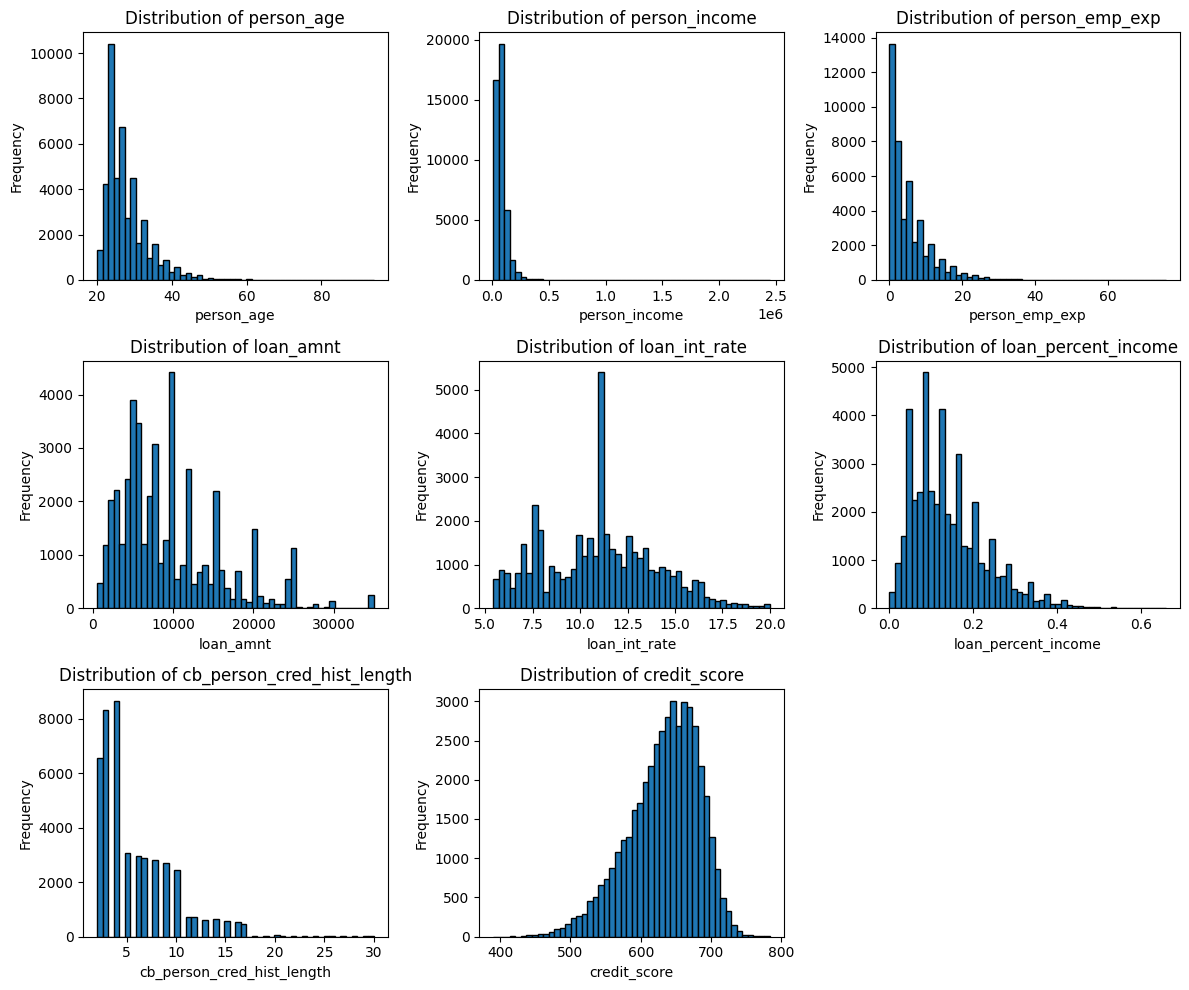

In [114]:
# Visualize the distribution of numeric features using histograms
plt.figure(figsize=(12, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    plt.hist(data[col], bins=50, edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Box Plots to Detect Outliers

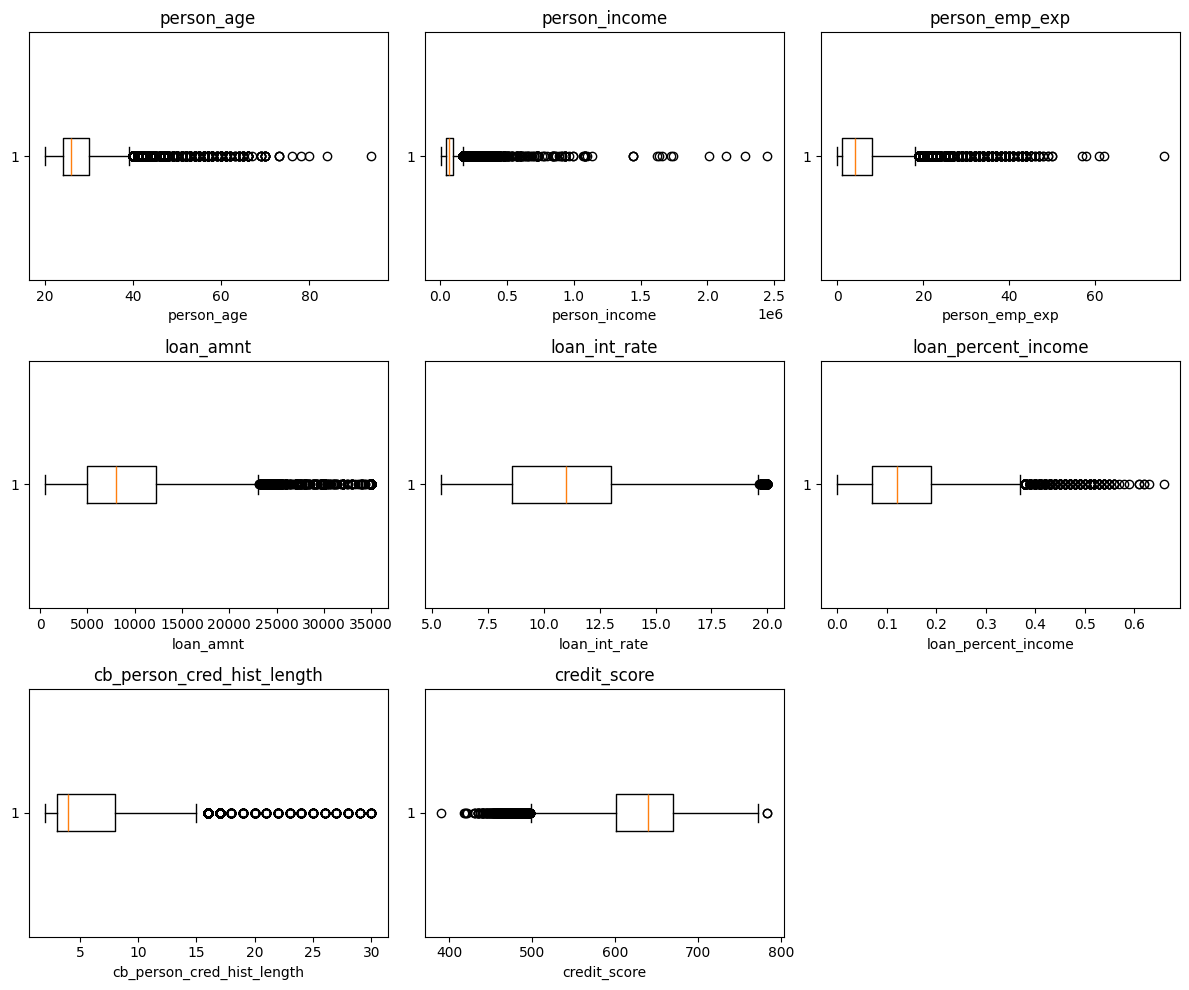

In [115]:
# Create box plots for numeric features to identify outliers
plt.figure(figsize=(12, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    plt.boxplot(data[col], vert=False)
    plt.title(f'{col}')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

## Fill Missing Values in Categorical Columns and Re-factorize

In [116]:
for col in categorical_cols:
    data[col] = data[col].fillna(data[col].mode()[0]) 
for col in categorical_cols:
    data[col], _ = pd.factorize(data[col])

## Correlation Heatmap

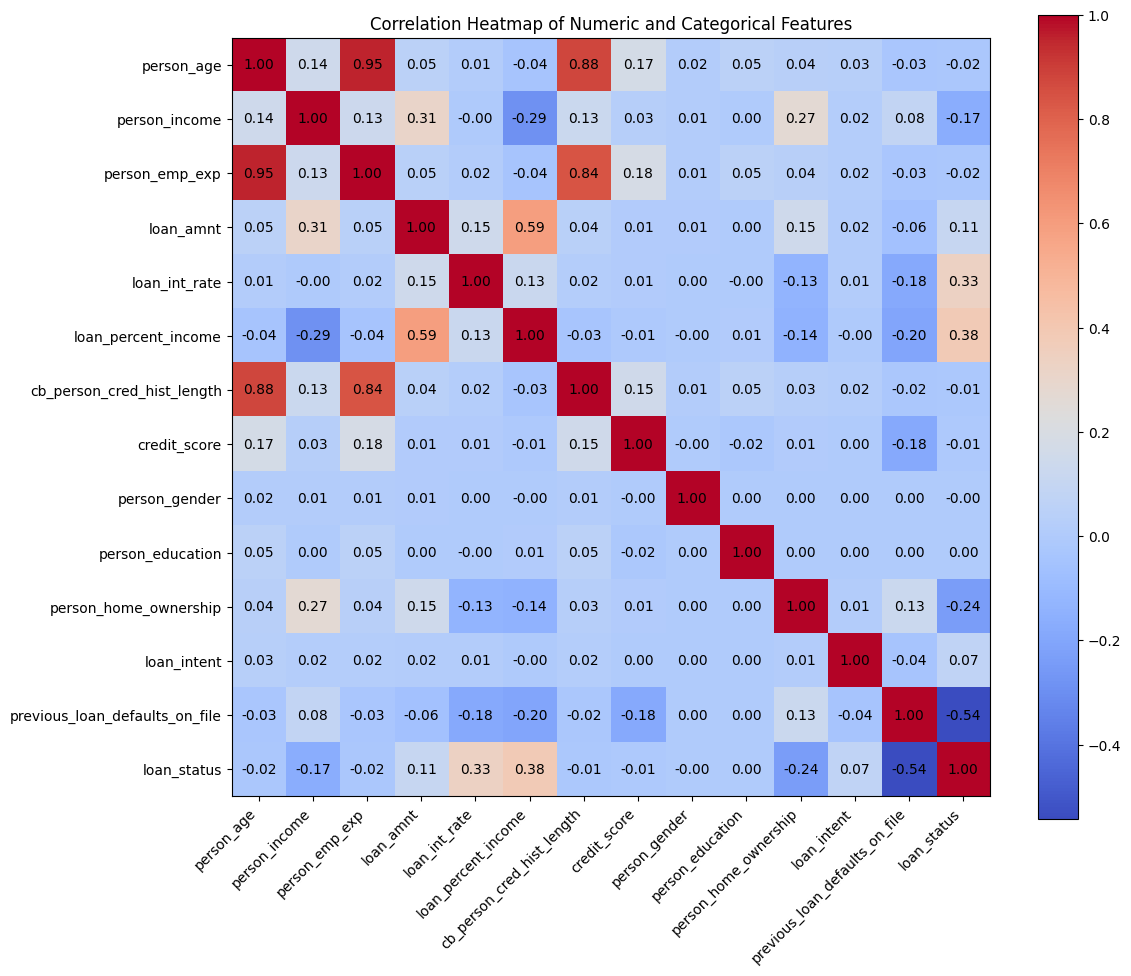

In [117]:
all_cols = numeric_cols + categorical_cols + ['loan_status']

corr_matrix = data[all_cols].corr()

plt.figure(figsize=(12, 10)) 
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(np.arange(len(all_cols)), all_cols, rotation=45, ha='right')
plt.yticks(np.arange(len(all_cols)), all_cols)
plt.title('Correlation Heatmap of Numeric and Categorical Features')

for i in range(len(all_cols)):
    for j in range(len(all_cols)):
        plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')

plt.tight_layout()
plt.show()


## Final Factorization of Categorical Features

In [118]:
for col in categorical_cols:
    data[col] = pd.factorize(data[col])[0]

## Normalize Numeric Columns

In [119]:
for col in numeric_cols:
    mean_val = data[col].mean()
    std_val = data[col].std()
    data[col] = (data[col] - mean_val) / std_val

## Prepare Feature Matrix (X) and Target Vector (y)

In [120]:
# Prepare features (X) and target variable (y) for modeling
X = data.drop('loan_status', axis=1)  # Features
y = data['loan_status'] # Target variable

## `Logistic Regression Model from Scratch`

### Define Sigmoid Function and Loss Function with Optional Regularization

In [121]:
# Define sigmoid activation function for logistic regression
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Define loss function with optional regularization
def compute_loss(y, y_pred, weights, lambda_reg=0.0, regularization=None):
    bce_loss = -np.mean(y * np.log(y_pred + 1e-15) + (1 - y) * np.log(1 - y_pred + 1e-15))

    # Add L2 regularization term if specified
    if regularization == "l2":
        l2_loss = (lambda_reg / 2) * np.sum(np.square(weights))
        return bce_loss + l2_loss
    else:
        return bce_loss

# Define prediction function for binary classification
def predict(X, weights, bias):
    linear_model = np.dot(X, weights) + bias
    y_pred = sigmoid(linear_model)
    return (y_pred >= 0.5).astype(int)  # Convert probabilities to binary predictions

### Logistic Regression Function Supporting Batch and SGD with Optional L2 Regularization

In [122]:
# Main logistic regression function supporting different optimization methods and regularization
def logistic_regression(X, y, lr=0.01, num_iterations=1000, lambda_reg=0.01,
                        method="batch", regularization=None):
    # Initialize parameters
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    bias = 0
    losses = []

    # Training loop
    for _ in range(num_iterations):
        if method == "batch":
            # Batch gradient descent - use entire dataset for each update
            linear_model = np.dot(X, weights) + bias
            y_pred = sigmoid(linear_model)
            error = y_pred - y

            # Compute gradients
            dw = (1 / n_samples) * np.dot(X.T, error)
            db = (1 / n_samples) * np.sum(error)

            # Add regularization term to weight gradients if using L2
            if regularization == "l2":
                dw += lambda_reg * weights

        elif method == "sgd":
            # Stochastic gradient descent - use a single random sample for each update
            idx = np.random.randint(0, n_samples)
            X_i = X.iloc[idx].values.reshape(1, -1)
            y_i = np.array([y.iloc[idx]])

            # Compute prediction and error for the selected sample
            linear_model = np.dot(X_i, weights) + bias
            y_pred = sigmoid(linear_model)
            error = y_pred - y_i

            # Compute gradients
            dw = np.dot(X_i.T, error)
            db = np.sum(error)

            # Add regularization term to weight gradients if using L2
            if regularization == "l2":
                dw += lambda_reg * weights
        else:
            raise ValueError("Method must be 'batch' or 'sgd'")

        # Update weights and bias using gradient descent
        weights -= lr * dw
        bias -= lr * db

        # Calculate loss on the entire dataset
        y_pred_full = sigmoid(np.dot(X, weights) + bias)
        loss = compute_loss(y, y_pred_full, weights, lambda_reg, regularization)
        losses.append(loss)

    return weights, bias, losses


## Define Model Variants (Loss Only, Ridge, SGD)

In [123]:
# Loss
def logistic_regression_loss(X, y, lr=0.01, num_iterations=1000):
    return logistic_regression(X, y, lr, num_iterations, lambda_reg=0.0, method="batch", regularization=None)

# Ridge Regularization - Batch
def logistic_regression_ridge(X, y, lr=0.01, num_iterations=1000, lambda_reg=0.01):
    return logistic_regression(X, y, lr, num_iterations, lambda_reg, method="batch", regularization="l2")

# SGD
def logistic_regression_sgd(X, y, lr=0.01, num_iterations=1000, lambda_reg=0.01, regularization=None):
    return logistic_regression(X, y, lr, num_iterations, lambda_reg, method="sgd", regularization=regularization)


## `Training Models and Evaluation`

## Train and Evaluate All Models

In [124]:
# Loss only
print("Training: Loss only")
w1, b1, loss1 = logistic_regression_loss(X, y)
for epoch in range(0, 100, 10):
    print(f"Epoch {epoch}, Loss: {loss1[epoch]:.4f}")
y_pred1 = sigmoid(np.dot(X, w1) + b1) >= 0.5

# L2 Regularization
print("Training: Ridge Regularization")
w2, b2, loss2 = logistic_regression_ridge(X, y)
for epoch in range(0, 100, 10):
    print(f"Epoch {epoch}, Loss: {loss2[epoch]:.4f}")
y_pred2 = sigmoid(np.dot(X, w2) + b2) >= 0.5

# SGD
print("Training: SGD")
w3, b3, loss3 = logistic_regression_sgd(X, y, regularization=None)
for epoch in range(0, 100, 10):
    print(f"[SGD] Epoch {epoch}, Loss: {loss3[epoch]:.4f}")
y_pred3 = sigmoid(np.dot(X, w3) + b3) >= 0.5

Training: Loss only
Epoch 0, Loss: 0.6841
Epoch 10, Loss: 0.6172
Epoch 20, Loss: 0.5776
Epoch 30, Loss: 0.5523
Epoch 40, Loss: 0.5349
Epoch 50, Loss: 0.5219
Epoch 60, Loss: 0.5116
Epoch 70, Loss: 0.5030
Epoch 80, Loss: 0.4956
Epoch 90, Loss: 0.4890
Training: Ridge Regularization
Epoch 0, Loss: 0.6841
Epoch 10, Loss: 0.6172
Epoch 20, Loss: 0.5778
Epoch 30, Loss: 0.5526
Epoch 40, Loss: 0.5353
Epoch 50, Loss: 0.5224
Epoch 60, Loss: 0.5123
Epoch 70, Loss: 0.5038
Epoch 80, Loss: 0.4965
Epoch 90, Loss: 0.4900
Training: SGD
[SGD] Epoch 0, Loss: 0.6775
[SGD] Epoch 10, Loss: 0.6809
[SGD] Epoch 20, Loss: 0.6103
[SGD] Epoch 30, Loss: 0.5770
[SGD] Epoch 40, Loss: 0.5432
[SGD] Epoch 50, Loss: 0.5305
[SGD] Epoch 60, Loss: 0.5352
[SGD] Epoch 70, Loss: 0.5215
[SGD] Epoch 80, Loss: 0.5227
[SGD] Epoch 90, Loss: 0.5111


## Define Evaluation Metrics

In [125]:
def calculate_precision_recall_f1(y_true, y_pred):
    """Calculate Precision, Recall, and F1 Score"""
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

    return precision, recall, f1

## Evaluate and Compare Models

Model: Loss
Accuracy : 0.8706
Precision: 0.8358
Recall   : 0.5202
F1 Score : 0.6413

Model: L2 Regularization
Accuracy : 0.8694
Precision: 0.8425
Recall   : 0.5072
F1 Score : 0.6332

Model: SGD
Accuracy : 0.8681
Precision: 0.8175
Recall   : 0.5233
F1 Score : 0.6381

Model                 Accuracy  Precision Recall    F1 Score  
Loss                  0.8706   0.8358    0.5202   0.6413
L2 Regularization     0.8694   0.8425    0.5072   0.6332
SGD                   0.8681   0.8175    0.5233   0.6381


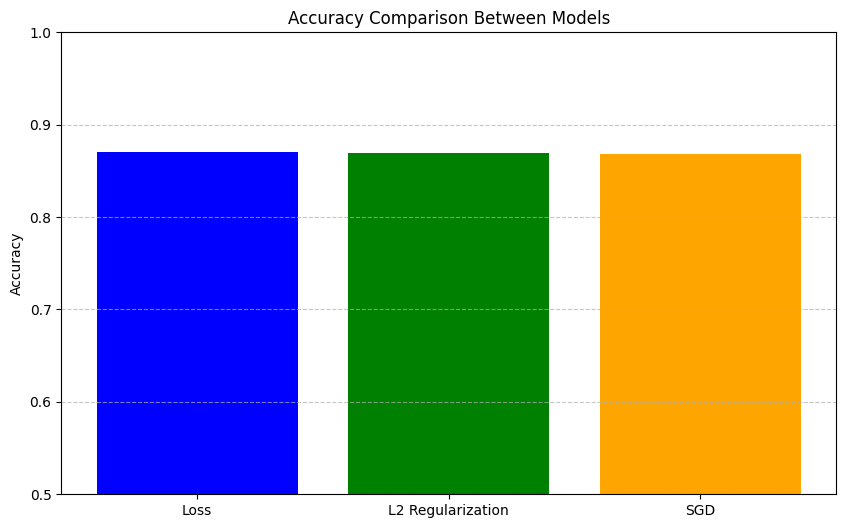

In [126]:
def calculate_accuracy(y_true, y_pred):
    """Calculate the accuracy of predictions"""
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = len(y_true)
    return correct_predictions / total_predictions

# Accuracy
accuracy1 = calculate_accuracy(np.array(y), np.array(y_pred1))
accuracy2 = calculate_accuracy(np.array(y), np.array(y_pred2))
accuracy3 = calculate_accuracy(np.array(y), np.array(y_pred3))

# Precision, Recall, F1
precision1, recall1, f1_1 = calculate_precision_recall_f1(np.array(y), y_pred1)
precision2, recall2, f1_2 = calculate_precision_recall_f1(np.array(y), y_pred2)
precision3, recall3, f1_3 = calculate_precision_recall_f1(np.array(y), y_pred3)

# Print all results nicely
print("Model: Loss")
print(f"Accuracy : {accuracy1:.4f}")
print(f"Precision: {precision1:.4f}")
print(f"Recall   : {recall1:.4f}")
print(f"F1 Score : {f1_1:.4f}\n")

print("Model: L2 Regularization")
print(f"Accuracy : {accuracy2:.4f}")
print(f"Precision: {precision2:.4f}")
print(f"Recall   : {recall2:.4f}")
print(f"F1 Score : {f1_2:.4f}\n")

print("Model: SGD")
print(f"Accuracy : {accuracy3:.4f}")
print(f"Precision: {precision3:.4f}")
print(f"Recall   : {recall3:.4f}")
print(f"F1 Score : {f1_3:.4f}\n")

# Optional: Table-style output
print("="*60)
print(f"{'Model':<22}{'Accuracy':<10}{'Precision':<10}{'Recall':<10}{'F1 Score':<10}")
print("="*60)
print(f"{'Loss':<22}{accuracy1:.4f}   {precision1:.4f}    {recall1:.4f}   {f1_1:.4f}")
print(f"{'L2 Regularization':<22}{accuracy2:.4f}   {precision2:.4f}    {recall2:.4f}   {f1_2:.4f}")
print(f"{'SGD':<22}{accuracy3:.4f}   {precision3:.4f}    {recall3:.4f}   {f1_3:.4f}")
print("="*60)

# Bar plot
plt.figure(figsize=(10, 6))
models = ["Loss", "L2 Regularization", "SGD"]
accuracies = [accuracy1, accuracy2, accuracy3]
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.ylim(0.5, 1.0)
plt.title("Accuracy Comparison Between Models")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Loss & Confusion Matrix Comparison

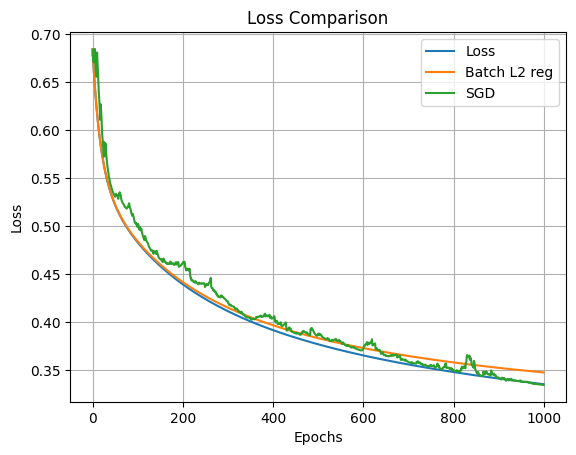

In [127]:
import matplotlib.pyplot as plt

plt.plot(loss1, label='Loss')
plt.plot(loss2, label='Batch L2 reg')
plt.plot(loss3, label='SGD')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()
plt.grid()
plt.show()


### Prediction Function

In [128]:
def predict(X, weights, bias):
    linear_model = np.dot(X, weights) + bias
    y_pred = sigmoid(linear_model)
    return (y_pred >= 0.5).astype(int)

### Confusion Matrix Function

In [129]:
def compute_confusion_matrix(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[TP, FP], [FN, TN]])

### Plot Multiple Confusion Matrices

In [130]:
def plot_all_conf_matrices_custom(y, preds, titles):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, (y_pred, title) in enumerate(zip(preds, titles)):
        cm = compute_confusion_matrix(np.array(y), np.array(y_pred))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i], cbar=False)
        axes[i].set_title(title)
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")
        axes[i].set_xticklabels(["Positive", "Negative"])
        axes[i].set_yticklabels(["Positive", "Negative"])

    plt.tight_layout()
    plt.show()


### Predictions & Titles

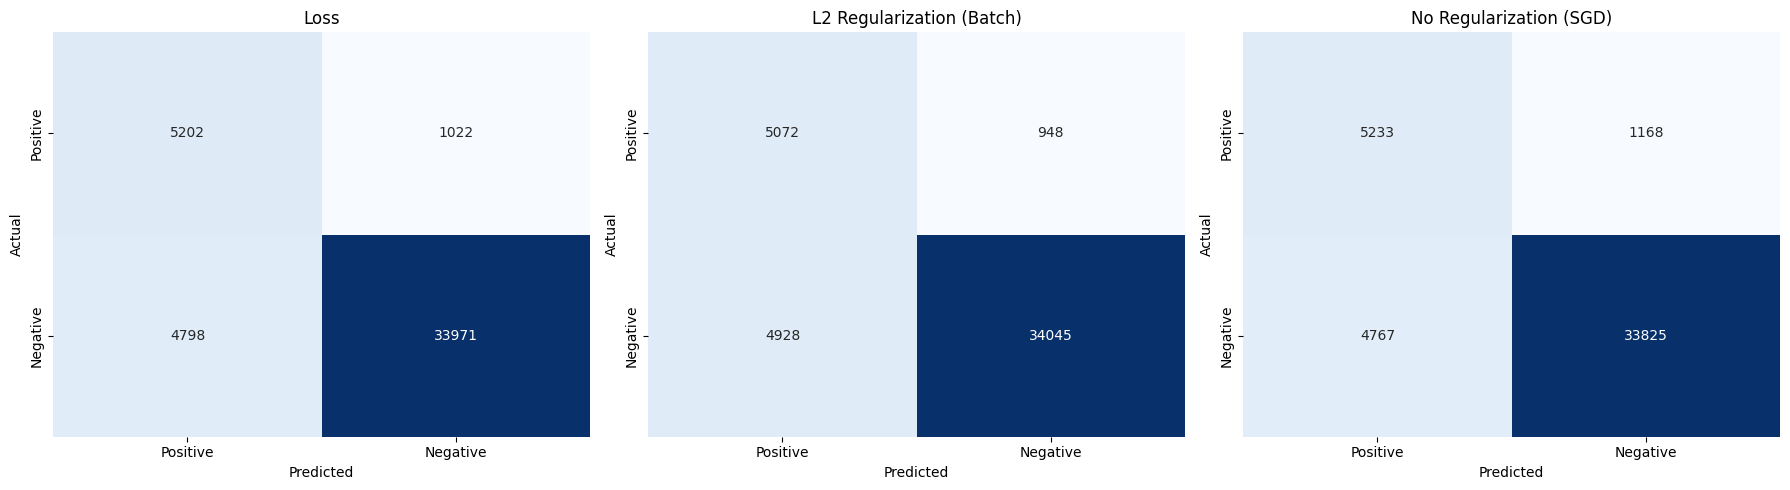

In [131]:
# predictions
y_pred1 = predict(X, w1, b1)
y_pred2 = predict(X, w2, b2)
y_pred3 = predict(X, w3, b3)

# titles
titles = [
    "Loss",
    "L2 Regularization (Batch)",
    "No Regularization (SGD)"
]
    
plot_all_conf_matrices_custom(y, [y_pred1, y_pred2, y_pred3], titles)

# `logistics model`

### `Algorithm With Sicikit Library`

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, log_loss
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


### Split Data

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression (No Regularization)

In [134]:
log_reg = LogisticRegression(penalty=None, max_iter=1000, solver='lbfgs')
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
y_pred_proba_log = log_reg.predict_proba(X_test)
loss_log = log_loss(y_test, y_pred_proba_log)
acc_log = accuracy_score(y_test, y_pred_log)

### Ridge Regression (L2 Regularization)

In [135]:

ridge_reg = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, solver='lbfgs')
ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)
y_pred_proba_ridge = ridge_reg.predict_proba(X_test)
loss_ridge = log_loss(y_test, y_pred_proba_ridge)
acc_ridge = accuracy_score(y_test, y_pred_ridge)


###  SGD Classifier

In [136]:

sgd_reg = SGDClassifier(loss='log_loss', penalty='l2', max_iter=1000, random_state=42)
sgd_reg.fit(X_train, y_train)
y_pred_sgd = sgd_reg.predict(X_test)
y_pred_proba_sgd = sgd_reg.predict_proba(X_test)
loss_sgd = log_loss(y_test, y_pred_proba_sgd)
acc_sgd = accuracy_score(y_test, y_pred_sgd)


### Final Results

In [137]:
print("\n Final Result with sklearn LogisticRegression models:")
print(f" - Loss Only:        Loss = {loss_log:.4f}, Accuracy = {acc_log:.4f}")
print(f" - Ridge:            Loss = {loss_ridge:.4f}, Accuracy = {acc_ridge:.4f}")
print(f" - SGDClassifier:    Loss = {loss_sgd:.4f}, Accuracy = {acc_sgd:.4f}")


 Final Result with sklearn LogisticRegression models:
 - Loss Only:        Loss = 0.2253, Accuracy = 0.8947
 - Ridge:            Loss = 0.2255, Accuracy = 0.8951
 - SGDClassifier:    Loss = 0.2289, Accuracy = 0.8924


### Accuracy Comparison Bar Chart

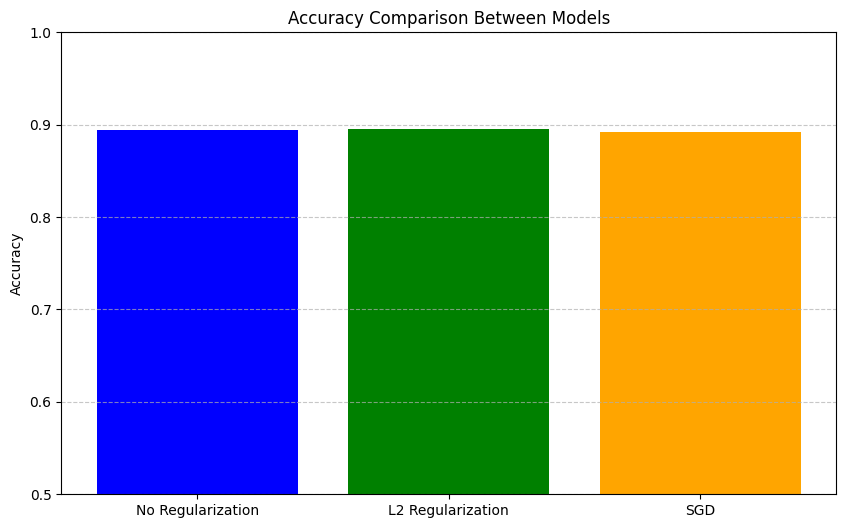

In [138]:
plt.figure(figsize=(10, 6))
models = ["No Regularization", "L2 Regularization", "SGD"]
accuracies = [acc_log, acc_ridge, acc_sgd]
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.ylim(0.5, 1.0)
plt.title("Accuracy Comparison Between Models")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Custom Confusion Matrix Plotting Function

In [139]:
def plot_all_conf_matrices_custom(y_true, preds, titles):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, (y_pred, title) in enumerate(zip(preds, titles)):
        cm = compute_confusion_matrix(np.array(y_true), np.array(y_pred))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i], cbar=False)
        axes[i].set_title(title)
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")
        axes[i].set_xticklabels(["Positive", "Negative"])
        axes[i].set_yticklabels(["Positive", "Negative"])
    plt.tight_layout()
    plt.show()

### Confusion Matrix Computation and Plotting

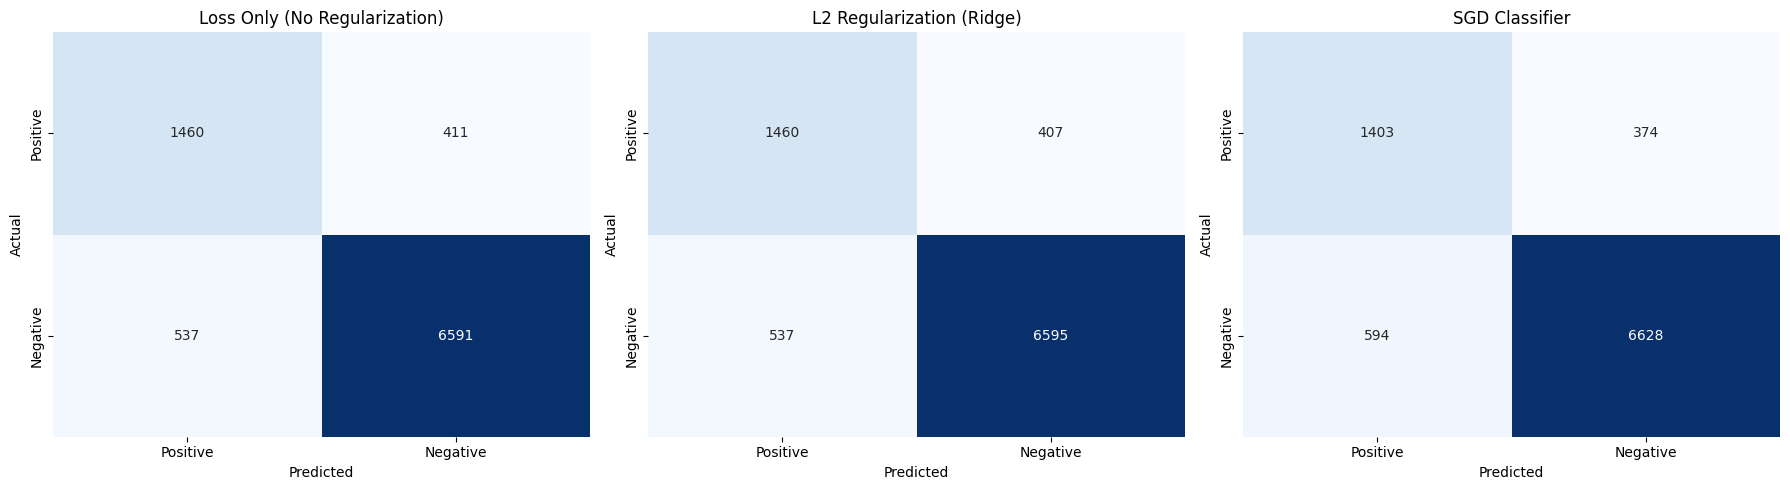

In [140]:
def compute_confusion_matrix(y_true, y_pred):
    # Calculate True Positives, True Negatives, False Positives, and False Negatives
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    # Return the confusion matrix as a 2x2 array
    return np.array([[TP, FP], [FN, TN]])

# Predictions from the models
y_preds = [y_pred_log, y_pred_ridge, y_pred_sgd]

# Titles for each confusion matrix plot
titles = [
    "Loss Only (No Regularization)",
    "L2 Regularization (Ridge)",
    "SGD Classifier"
]

# Plot confusion matrices using the custom function
plot_all_conf_matrices_custom(y_test, y_preds, titles)


### `DONE!!!!!`